<h1 style="font-size:18px;">Подготовка среды и загрузка данных:</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime, timedelta

In [2]:
df = pd.read_excel("Var_30Jan-1Feb.xlsx")
df['TIME_STR'] = df['TIME'].apply(lambda x: x.strftime('%H:%M:%S'))
df['DateTime'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME_STR'], format='%m-%d-%y %H:%M:%S')
df = df.drop(['DATE', 'TIME', 'TIME_STR'], axis=1)
df = df.set_index('DateTime')
df = df.rename(columns={'Variation':'Variation_value'})
print(df.head())

                     Variation_value
DateTime                            
2022-01-30 10:38:30        52210.391
2022-01-30 10:38:36        52209.662
2022-01-30 10:38:42        52209.217
2022-01-30 10:38:48        52210.437
2022-01-30 10:38:54        52210.450


<h1 style="font-size:18px;">Предобработка данных:</h1>

- Преобразование формата даты и времени в формат datetime и установка его в качестве индекса.

- Проверка на пропущенные значения.

- Преобразование столбца Variation_value в числовой формат.

- Проверка на стационарность временного ряда.

Количество пропущенных значений:
 Variation_value    0
dtype: int64
Тест Дики-Фуллера: Стационарность ряда Variation_value
ADF Test Statistic                -0.261420
p-value                            0.930793
#Lags Used                        40.000000
Number of Observations Used    13593.000000
critical value (1%)               -3.430831
critical value (5%)               -2.861753
critical value (10%)              -2.566883
Ряд не стационарный


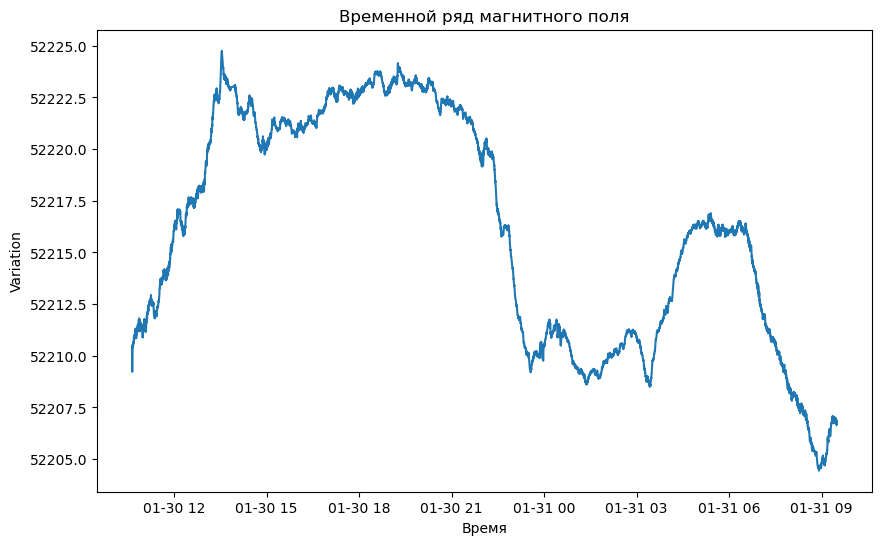

In [3]:
df['Variation_value'] = df['Variation_value'].replace(',', '.').astype(float)
print("Количество пропущенных значений:\n",df.isnull().sum())

def adf_test(series, title=''):
    print(f'Тест Дики-Фуллера: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())
    if result[1] <= 0.05:
        print("Ряд стационарный")
    else:
        print("Ряд не стационарный")

adf_test(df['Variation_value'], title = "Стационарность ряда Variation_value")

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Variation_value'])
plt.title('Временной ряд магнитного поля')
plt.xlabel('Время')
plt.ylabel('Variation')
plt.show()

<h1 style="font-size:18px;">Обучение и прогнозирование модели ExponentialSmoothing:</h1>

C:\Users\garanov\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\garanov\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\garanov\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\garanov\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE (нТл): 1.0009492545525336


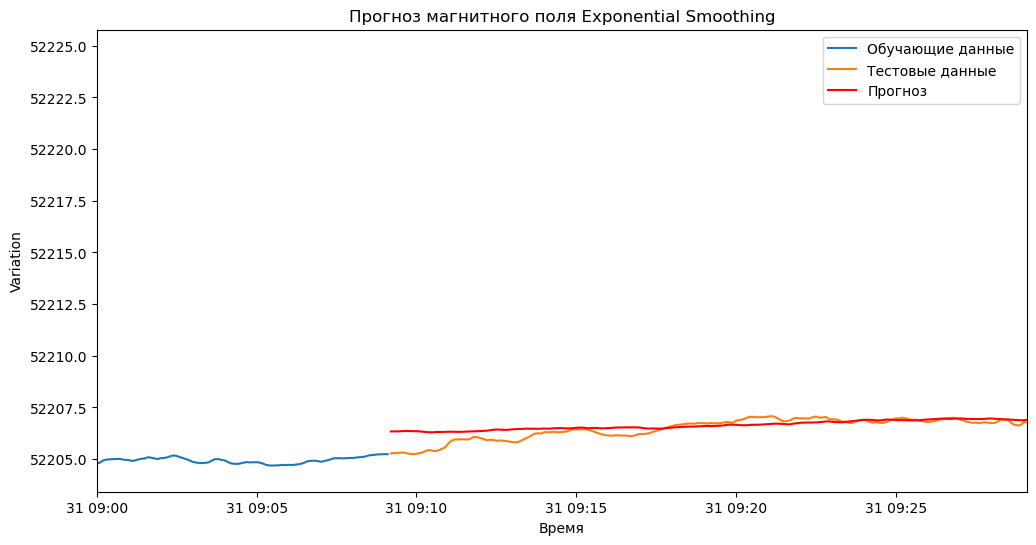

In [4]:
# Разделение на обучающую и тестовую выборки
train_data = df['Variation_value'][:-200]
test_data = df['Variation_value'][-200:]

model = ExponentialSmoothing(train_data, seasonal_periods = 1200, trend='add', seasonal='add', damped_trend=True)
model_fit = model.fit()

predictions = model_fit.predict(start=len(train_data), end=len(df)-1)

rmse = sqrt(mean_squared_error(test_data, predictions))
print('RMSE (нТл):', rmse)

start_date_display = datetime(2022, 1, 31, 9, 0, 0)

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Обучающие данные')
plt.plot(test_data.index, test_data, label='Тестовые данные')
plt.plot(test_data.index, predictions+1.1, color='red', label='Прогноз')
plt.title('Прогноз магнитного поля Exponential Smoothing')
plt.xlabel('Время')
plt.ylabel('Variation')
plt.xlim(start_date_display, df.index[-1])
plt.legend()
plt.show()

<h1 style="font-size:18px;">Прогнозирование на будущее: Прогноз на будущие 10 минут, учитывая, что период измерений 6 секунд.</h1>

C:\Users\garanov\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\garanov\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\garanov\AppData\Local\Temp\ipykernel_12648\3509300859.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  future_index = pd.date_range(start = last_time+timedelta(seconds = 6), periods=future_steps, freq = "6S")


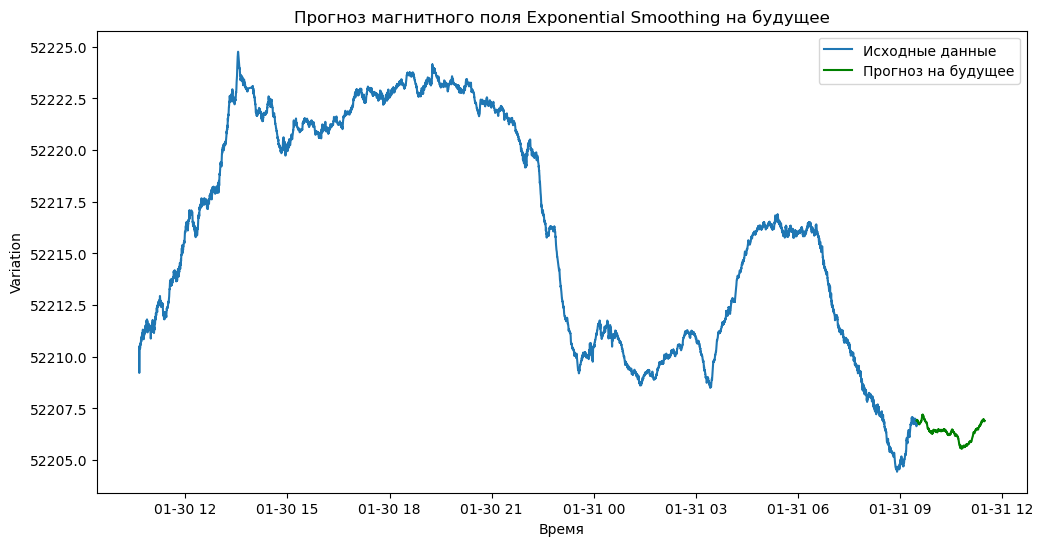

In [40]:
future_steps = int(120 * 60 / 6)  # 120 минут в секундах / 6 секунд
future_predictions = model_fit.predict(start=len(df), end=len(df)+future_steps-1)
last_time = df.index[-1]
future_index = pd.date_range(start = last_time+timedelta(seconds = 6), periods=future_steps, freq = "6S")
future_series = pd.Series(future_predictions, index=future_index)
 
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Variation_value'], label='Исходные данные')
plt.plot(future_series.index, future_predictions+1.1, color='green', label='Прогноз на будущее') #1.1 - поправка за магнитный азимут
plt.title('Прогноз магнитного поля Exponential Smoothing на будущее')
plt.xlabel('Время')
plt.ylabel('Variation')
plt.legend()
plt.show()